Data Duplication Removal using Machine Learning Model


In [24]:
import pandas as pd
import numpy as np
import os
import time
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt

# Your code logic would go here



<Axes: xlabel='is_duplicate'>

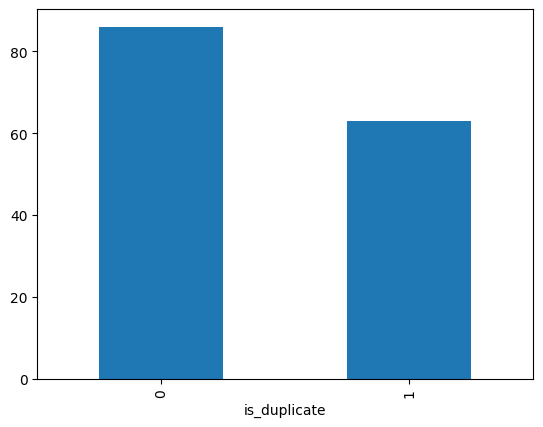

In [25]:
data = pd.read_csv('Input.csv')
data['is_duplicate'].value_counts().plot(kind='bar')

In [26]:
data

,ln,dob,gn,fn,is_duplicate
0,SMITH JR,01-03-1968,F,WILLIAM,0
1,ROTHMEYER JR,01-03-1968,F,WILLIAM,0
2,BLAND III,21-02-1962,F,WILLIAM,1
3,BLAND JR,21-02-1962,F,BILL,0
4,BLAND,21-02-1962,F,WILLIAM,1
...,...,...,...,...,...
144,PRERNA,17-11-1945,F,CHOPRA,0
145,PRERNA,07-10-1937,F,BHENDARKAR,0
146,PRERNA,07-10-1937,F,BHENDARKAR,1
147,ANSHUL,20-10-1953,F,SHARMA,0


In [27]:
data['name'] = data.fn +' '+ data.ln

In [28]:
import hashlib
import base64
import pandas as pd

# Assuming `data` is already defined and loaded
# Concatenate the columns into a new column 'concat'
data['concat'] = data['dob'].astype(str) + data['gn'] + data['fn'] + data['ln']

# Function to create a base64 encoded hash
def create_hash(value):
    # Encode the string and create a hash
    hash_object = hashlib.sha256(value.encode('utf-8'))
    hash_bytes = hash_object.digest()
    return base64.b64encode(hash_bytes).decode('utf-8')

# Apply the function to the 'concat' column to create the 'hash' column
data['hash'] = data['concat'].apply(create_hash)

# Display the DataFrame
data.head()


,ln,dob,gn,fn,is_duplicate,name,concat,hash
0,SMITH JR,01-03-1968,F,WILLIAM,0,WILLIAM SMITH JR,01-03-1968FWILLIAMSMITH JR,S9gYAsHHNRwyxt7D9oEMlu73wSetxxUGyX58ORkV7cM=
1,ROTHMEYER JR,01-03-1968,F,WILLIAM,0,WILLIAM ROTHMEYER JR,01-03-1968FWILLIAMROTHMEYER JR,6Fls5yBD08Nlr+q2du5b8k3hBx3Ytxv6ja2fDmZwxdA=
2,BLAND III,21-02-1962,F,WILLIAM,1,WILLIAM BLAND III,21-02-1962FWILLIAMBLAND III,VXn8FfWq6WrLWvQtuskpYa60WOH0v0PoZru4yB5TeUA=
3,BLAND JR,21-02-1962,F,BILL,0,BILL BLAND JR,21-02-1962FBILLBLAND JR,P+Gu/Ir1CY8oZH40kOhJ4F57vhf/Z+5ds5L7GhItOPY=
4,BLAND,21-02-1962,F,WILLIAM,1,WILLIAM BLAND,21-02-1962FWILLIAMBLAND,Pinp3bS1Ok0OevEHhaor4YPFeTk9/ZrwSBy8pdMfoYw=


In [29]:
###* A list of unique dates of birth and unique genders is obtained.
unique_dob = data.dob. unique ( )
unique_sex = data. gn. unique ( )
unique_hash = data.hash. unique()

In [30]:
pip install Distance

Note: you may need to restart the kernel to use updated packages.


In [31]:
import distance

In [32]:
import time
import numpy as np
from sklearn.metrics import f1_score
import distance  # Ensure you have the 'distance' package installed

def deduplication_model(data, scoring_range=10, step=2):
    # Initialize the start time
    starth = time.time()
    
    # Assign indices
    data['indices'] = list(range(len(data)))
    accuracy = []
    index = []
    final_step = 0
    
    # Get unique hashes
    unique_hash = data['hash'].unique()
    
    for value in range(scoring_range):
        for i in unique_hash:
            sample = data[data.hash == i].reset_index(drop=True)
            for a in range(len(sample)):
                comparison = sample[sample.indices != sample.indices[a]].reset_index(drop=True)
                
                # Calculate Levenshtein scores
                scores = [distance.levenshtein(sample.name[a], comparison.name[x]) for x in range(len(comparison))]
                compare_indices = [comparison.indices[x] for x in range(len(comparison))]
                
                try:
                    if sample.indices[a] > compare_indices[scores.index(min(scores))]:
                        score = min(scores)
                        if score <= value:
                            index.append(sample.indices[a])
                except ValueError:
                    pass
        
        prediction = []
        for k in range(len(data)):
            if data.indices[k] in index:
                prediction.append(1)
            else:
                prediction.append(0)
        
        data['prediction'] = prediction
        
        # Calculate and store F1 score
        f1 = f1_score(data.is_duplicate, data.prediction, average='macro')
        accuracy.append(f1)
        print('F1-score after', value, 'iterations: ', f1)
        
        # Check if the accuracy is not improving
        if len(accuracy) > 1 and accuracy[-1] <= accuracy[-2]:
            final_step += 1
            if final_step > step:
                break

    return prediction, value

# Note: Ensure that 'data' DataFrame and 'distance' module are properly defined before calling this function.


In [33]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train, test = train_test_split(data, test_size=0.05, stratify=data['is_duplicate'])

# Reset the indices of train and test sets
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

# Call the deduplication model
performance, levenshtein_value_optimum = deduplication_model(train, scoring_range=10)

# Display results (if needed)
#performance, levenshtein_value_optimum


F1-score after 0 iterations:  0.7128001715265866
F1-score after 1 iterations:  0.7128001715265866
F1-score after 2 iterations:  0.7128001715265866
F1-score after 3 iterations:  0.7128001715265866


In [34]:
import numpy as np
import distance  # Ensure you have the 'distance' package installed

def deduplication_prediction(data, optimum_value):
    data['indices'] = list(range(len(data)))
    index = []
    unique_hash = data['hash'].unique()  # Get unique hashes

    for i in unique_hash:
        sample = data[data['hash'] == i].reset_index(drop=True)
        
        for a in range(len(sample)):
            comparison = sample[sample.indices != sample.indices[a]].reset_index(drop=True)
            scores = [distance.levenshtein(sample.name[a], comparison.name[x]) for x in range(len(comparison))]
            compare_indices = [comparison.indices[x] for x in range(len(comparison))]
            
            try:
                # Check if the sample index is greater than the best comparison index
                if sample.indices[a] > compare_indices[scores.index(min(scores))]:
                    score = min(scores)
                    if score <= optimum_value:
                        index.append(sample.indices[a])
            except ValueError:
                pass  # If no minimum score is found, just skip

    # Generate predictions
    prediction = []
    for k in range(len(data)):
        if data.indices[k] in index:
            prediction.append(1)
        else:
            prediction.append(0)
    
    data['prediction'] = prediction
    return prediction


In [35]:
predictions = deduplication_prediction(test, levenshtein_value_optimum)


In [36]:
print( 'Fl-score on test set:', accuracy_score(test.is_duplicate, predictions) )

Fl-score on test set: 0.625


In [37]:
# Assign predictions to train and test DataFrames
train['prediction'] = performance
test['prediction'] = predictions

# Concatenate train and test DataFrames
dataset = pd.concat([train, test], axis=0)

# Reset index after concatenation and filter the dataset
dataset = dataset[dataset['prediction'] == 1].reset_index(drop=True)


In [38]:
import time

# Start timing
starth = time.time()

# Your code logic goes here

# Save the dataset to a CSV file
dataset.to_csv('Output_given123.csv', index=False)

# Calculate the time taken
end_h = time.time()
tt2 = end_h - starth  # Calculate the elapsed time

# Print the time taken
print('Time taken:', tt2)


Time taken: 0.015310049057006836


In [39]:
import time

# Start timing
starth = time.time()

# Your code logic goes here

# Save the dataset to a CSV file
dataset.to_csv('Output_given111.csv', index=True)

# Calculate the time taken
end_h = time.time()
tt2 = end_h - starth  # Calculate the elapsed time

# Print the time taken
print('Time taken:', tt2)


Time taken: 0.006526470184326172


In [40]:
datal = pd.read_csv( 'Output_given111.csv' )
datal.head()

,Unnamed: 0,ln,dob,gn,fn,is_duplicate,name,concat,hash,indices,prediction
0,0,MELVIN JR,07-10-1937,M,HAROLD,1,HAROLD MELVIN JR,07-10-1937MHAROLDMELVIN JR,tJkvI+4mGqlhefPLI7RuxXZRivL4x2kc6tJwwhzdjfE=,2,1
1,1,SALTER JR,01-03-1968,F,WILLIAM,1,WILLIAM SALTER JR,01-03-1968FWILLIAMSALTER JR,NBH8f7yo84rwK9qFN5gU8cyDMppgLxxg/GYx+RVyzy0=,33,1
2,2,MELVIN JR,07-10-1937,M,HAROLD,1,HAROLD MELVIN JR,07-10-1937MHAROLDMELVIN JR,tJkvI+4mGqlhefPLI7RuxXZRivL4x2kc6tJwwhzdjfE=,37,1
3,3,SHAFFER JR,21-02-1962,F,WILLIAM,0,WILLIAM SHAFFER JR,21-02-1962FWILLIAMSHAFFER JR,4pHqo2AbDMlfhy+u6w/x2Oz5qtCrpsB4rrkxPSFhNVk=,38,1
4,4,DHONI,07-10-1937,M,SINGH,1,SINGH DHONI,07-10-1937MSINGH DHONI,SV65DDxMRRH26jHN5O9Xn4oZyMt+Nv45PsUDLaT3XCA=,44,1


In [41]:
datal

,Unnamed: 0,ln,dob,gn,fn,is_duplicate,name,concat,hash,indices,prediction
0,0,MELVIN JR,07-10-1937,M,HAROLD,1,HAROLD MELVIN JR,07-10-1937MHAROLDMELVIN JR,tJkvI+4mGqlhefPLI7RuxXZRivL4x2kc6tJwwhzdjfE=,2,1
1,1,SALTER JR,01-03-1968,F,WILLIAM,1,WILLIAM SALTER JR,01-03-1968FWILLIAMSALTER JR,NBH8f7yo84rwK9qFN5gU8cyDMppgLxxg/GYx+RVyzy0=,33,1
2,2,MELVIN JR,07-10-1937,M,HAROLD,1,HAROLD MELVIN JR,07-10-1937MHAROLDMELVIN JR,tJkvI+4mGqlhefPLI7RuxXZRivL4x2kc6tJwwhzdjfE=,37,1
3,3,SHAFFER JR,21-02-1962,F,WILLIAM,0,WILLIAM SHAFFER JR,21-02-1962FWILLIAMSHAFFER JR,4pHqo2AbDMlfhy+u6w/x2Oz5qtCrpsB4rrkxPSFhNVk=,38,1
4,4,DHONI,07-10-1937,M,SINGH,1,SINGH DHONI,07-10-1937MSINGH DHONI,SV65DDxMRRH26jHN5O9Xn4oZyMt+Nv45PsUDLaT3XCA=,44,1
5,5,SIDDHARTH,16-12-1944,M,CHATERJEE,0,CHATERJEE SIDDHARTH,16-12-1944MCHATERJEESIDDHARTH,l6yOoAuwY35M3NnVXxW3td2RdHam2y8WYkjeptM/Fmg=,45,1
6,6,FAGEN JR,07-10-1937,M,HAROLD,0,HAROLD FAGEN JR,07-10-1937MHAROLDFAGEN JR,EpirvtJYvn98nfdM3S9oHFCi6xbDlFtBq3Z0fQgYyg8=,47,1
7,7,CHAVAS JR,07-10-1937,M,HAROLD,1,HAROLD CHAVAS JR,07-10-1937MHAROLDCHAVAS JR,ilSQ9dpizK4kjv1Hx39VVDtGWXjZs2PhQgREqiY7fpc=,52,1
8,8,MICHAELSON JR,07-10-1937,M,HAROLD,0,HAROLD MICHAELSON JR,07-10-1937MHAROLDMICHAELSON JR,dj/CF8jEYlwijg9ysuBrfI68WiGdOir7HqQ3bqXTCDg=,53,1
9,9,MELVIN JR,07-10-1937,M,HAROLD,1,HAROLD MELVIN JR,07-10-1937MHAROLDMELVIN JR,tJkvI+4mGqlhefPLI7RuxXZRivL4x2kc6tJwwhzdjfE=,58,1
